In [1]:
from config import Param
from methods.utils import setup_seed
from dataloaders.sampler import data_sampler
from dataloaders.data_loader import get_data_loader
from methods.backbone import *

param = Param()
args = param.args
args.dataname = "TACRED"
args.task_name = args.dataname
args.seed = 2421
args.rel_per_task = 8 if args.dataname == "FewRel" else 4
sampler = data_sampler(args=args, seed=args.seed)

In [2]:
args.bert_path = "/home/thhiep/dta/CRL-Shaw-48/checkpoint/bert"
encoder = BertRelationEncoder(config=args).to(args.device)

Some weights of BaseBertEncoder were not initialized from the model checkpoint at /home/thhiep/dta/CRL-Shaw-48/checkpoint/bert and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.out

In [29]:
from methods.prompt import Prompt


args.prompt_length = 1
args.prompt_top_k = 8
args.prompt_pool_size = 80
prompt_length_1 = Prompt(args).to(args.device)
prompt_length_1.load_state_dict(torch.load("/home/thhiep/dta/CRL-Shaw-48/checkpoint/prompt_length_1_task_1.pt"))

args.prompt_length = 80
args.prompt_top_k = 1
args.prompt_pool_size = 1
prompt_length_80 = Prompt(args).to(args.device)
prompt_length_80.load_state_dict(torch.load("/home/thhiep/dta/CRL-Shaw-48/checkpoint/prompt_length_80_task_1.pt"))

<All keys matched successfully>

In [4]:
data = {}
for steps, (training_data, valid_data, test_data, current_relations, historic_test_data, seen_relations) in enumerate(sampler):
    if steps == 0:
        for i, relation in enumerate(current_relations):
            print(relation)
            print(len(test_data[relation]))
            data[relation] = test_data[relation]

org:alternate_names
41
per:charges
35
per:schools_attended
35
per:cause_of_death
33


In [30]:
for key, value in enumerate(data):
    print(value)
    print(len(data[value]))

org:alternate_names
41
per:charges
35
per:schools_attended
35
per:cause_of_death
33


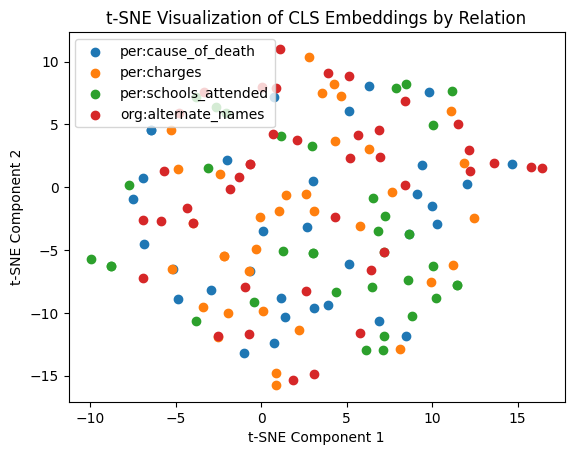

In [36]:
import torch
from transformers import BertModel, BertTokenizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def visualize_cls_embedding(data, model, prompt, args, n_components=2, perplexity=30, learning_rate=200):
    model.eval()
    prompt.eval()
    data_relation = {}
    total_data = []
    total_labels = []

    # Collecting embeddings for each relation in data
    for relation in data:
        data_loader = get_data_loader(args, data[relation], shuffle=True, batch_size=1)
        for step, (labels, tokens, _) in enumerate(data_loader):
            with torch.no_grad():
                tokens = torch.stack([x.to(args.device) for x in tokens], dim=0)
                outputs = model(tokens)["x_encoded"]
                outputs = model(tokens, prompt, outputs)["x_encoded"].cpu().detach().numpy()

            # Append the embeddings and labels to the total list
            total_data.append(outputs)
            total_labels.extend([relation] * outputs.shape[0])

    # Flattening the list of embeddings
    total_data = np.vstack(total_data)

    # Apply t-SNE to the combined embeddings
    tsne = TSNE(n_components=n_components, learning_rate=learning_rate)
    tsne_results = tsne.fit_transform(total_data)

    # Plotting the t-SNE results
    fig = plt.figure()
    if n_components == 2:
        for relation in set(total_labels):
            indices = [i for i, label in enumerate(total_labels) if label == relation]
            plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=relation)
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
    elif n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        for relation in set(total_labels):
            indices = [i for i, label in enumerate(total_labels) if label == relation]
            ax.scatter(tsne_results[indices, 0], tsne_results[indices, 1], tsne_results[indices, 2], label=relation)
        ax.set_xlabel('t-SNE Component 1')
        ax.set_ylabel('t-SNE Component 2')
        ax.set_zlabel('t-SNE Component 3')

    plt.legend()
    plt.title('t-SNE Visualization of CLS Embeddings by Relation')
    plt.show()

    
visualize_cls_embedding(
    data=data,
    model=encoder,
    prompt=prompt_length_80,
    args=args,
    n_components=2,
    perplexity=5,
    learning_rate=200
)
